In [2]:
import astropy.io.fits as fits
import des_functions
import treecorr
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import locate
import time
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
data_dir = '/home/b7009348/projects/WGL_Project/DES-data/'

# Calculating $(1-a)\bar{\gamma}_{IA}$

### Define parameters for use in all calculations

In [3]:
# define bin and scale params
nbins=20
npatches=20
theta_min=2.5
theta_max=250

### Set paths to required files

In [9]:
# paths to required files
data_dir = '/home/b7009348/WGL_project/DES-data/'
lens_file = 'DES_Y1A1_Lenses_z=0.3-0.45.fits'
source_Zs = 'mof_BPZ_(stacking).fits'
im3_file = 'y1_im3_shapes_matched.fits'
mcal_file = 'y1_mcal_shapes_matched.fits'

### Define functions to calculate tangential shear and boost within JK loop

In [5]:
#define function compute tangential shear for im3shape estimator
def im3_tangential_shear(cat_l, cat_s, cat_r, cat_k, nbins):
    
    gammat = np.zeros([nbins])
    theta = np.zeros_like(gammat)
    
    # do correlations with lenese, NKCorrelation is used to apply multiplicative correction
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ng.process(cat_l, cat_s)
    nk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    nk.process(cat_l, cat_k)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rg.process(cat_r, cat_s)
    rk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rk.process(cat_r, cat_k)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    sens_l = nk.xi
    xi_r = rg.xi
    sens_r = rk.xi
    
    # store data in preallocated arrays
    gammat = xi_l/sens_l - xi_r/sens_r
    theta = np.exp(ng.meanlogr)
    
    del ng, rg, nk, rk, xi_l, sens_l, xi_r, sens_r
    
    return gammat, theta

# define function to compute boost
def calculate_boost(cat_l, cat_s, cat_r, nbins):
    
    boost = np.zeros([nbins])
    
    # do count correlations to find boost
    ls = treecorr.NNCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ls.process(cat_l, cat_s)

    rs = treecorr.NNCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rs.process(cat_r, cat_s)
    
    nrand = cat_r.nobj
    nlens = cat_l.nobj
    
    boost = nrand/nlens * ls.weight/rs.weight
    
    del ls, rs, nrand, nlens
    
    return boost

# define function to compute metacalibration tangential shear
def mcal_tangential_shear(cat_l, cat_s, cat_r, nbins, R):
    
    gammat = np.zeros([nbins])
    theta = np.zeros_like(gammat)
    
    # do correlations with lenses
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ng.process(cat_l, cat_s)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rg.process(cat_r, cat_s)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    xi_r = rg.xi
    
    # store data in preallocated arrays
    gammat = 1.0/R * (xi_l - xi_r)
    theta = np.exp(ng.meanlogr)
    
    del ng, rg, xi_l, xi_r
    
    return gammat, theta

### Create lens catalogue to set patches

In [38]:
# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
# pass in npatch arguement to create catalogue using patches    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=npatches)

del data, ra_l, dec_l, w_l

print('lens catalogue created...')

lens catalogue created...


 ### Cary out jackknife estimate for errors

In [39]:
IA_signal = np.zeros([npatches, nbins])
IA_theta = np.zeros_like(IA_signal)

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
# pass in npatch arguement to create catalogue using patches    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=npatches)

del data, ra_l, dec_l, w_l

print('lens catalogue created...')

#loop to exclude 1 patch at a time
print('Beginning Jackknife estimate...')
for i in range(npatches):
    
    im3_gammat = np.zeros([nbins])
    im3_theta = np.zeros_like(im3_gammat)
    mcal_gammat = np.zeros_like(im3_gammat)
    mcal_theta = np.zeros_like(im3_gammat)
    boost = np.zeros_like(im3_gammat)
    F = np.zeros_like(im3_gammat)
    
    start = time.time()
    
    # read in randoms data and create treecorr catalogue
    with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
        data = hdu[1].data
        indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
        ra_r = data['RA'][indexes]
        dec_r = data['dec'][indexes]
        rand_z = data['z'][indexes]
    
    # define patches based on patches from lens catalogue so all catalogues use the same patches    
    cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', r=rand_z, patch_centers=cat_l.patch_centers)

    del data, ra_r, dec_r, rand_z, indexes

    # read in im3shape data 
    with fits.open(data_dir+im3_file) as hdu:
        data = hdu[1].data
        im3_ID = data['coadd_objects_id']
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1'] - data['c1']
        e2 = data['e2'] - data['c2']
        sens = data['m'] + 1.0
        w = data['weight']
    del data
    
    # load in z_mc for all sources
    with fits.open(data_dir+source_Zs) as hdu:
        data = hdu[1].data
        im3_zmc = data['z_mc']
        zmc_ID = data['coadd_objects_id']
    del data

    # match z_mc values to source IDs
    matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

    # slice z_mc values to only to those in matched catalogue
    im3_zmc = im3_zmc[zmc_indices]

    # delete uneccessary arrays
    del matches, zmc_indices, shape_indices, zmc_ID, im3_ID
    
    # create catalogues for im3shape measurements and multiplicative bias calculation
    cat_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=im3_zmc, g1=e1, g2=e2, w=w, patch_centers=cat_l.patch_centers)
    cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w, patch_centers=cat_l.patch_centers)

    del ra_s, dec_s, w, e1, e2, sens, im3_zmc

    # read in metacalibration data
    with fits.open(data_dir+mcal_file) as hdu:
        data = hdu[1].data
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1']
        e2 = data['e2']
        R11 = data['R11'] # e1-e1
    
    # responsivity values for this patch
    cat_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=R11, g1=e1, g2=e2, patch_centers=cat_l.patch_centers)

    del data, ra_s, dec_s, e1, e2, R11

    print('ALL CATALOGUES READY')
    
    #locate patch in catlogues
    l_indexes = list(locate(cat_l.patch, lambda x: x != i))
    r_indexes = list(locate(cat_r.patch, lambda x: x != i))
    im3_indexes = list(locate(cat_im3.patch, lambda x: x != i))
    k_indexes = list(locate(cat_k.patch, lambda x: x != i))
    mcal_indexes = list(locate(cat_mcal.patch, lambda x: x != i))
    
    print('Patch %g located...' %i)
    
    #create new catalogues with this patch missing
    jk_l = treecorr.Catalog(ra=cat_l.ra[l_indexes], dec=cat_l.dec[l_indexes], ra_units='rad', dec_units='rad', w=cat_l.w[l_indexes])
    
    jk_r = treecorr.Catalog(ra=cat_r.ra[r_indexes], dec=cat_r.dec[r_indexes], ra_units='rad', dec_units='rad')
    
    jk_im3 = treecorr.Catalog(ra=cat_im3.ra[im3_indexes], dec=cat_im3.dec[im3_indexes], ra_units='rad', dec_units='rad', g1=cat_im3.g1[im3_indexes], 
                                g2=cat_im3.g2[im3_indexes], w=cat_im3.w[im3_indexes])
    
    jk_k = treecorr.Catalog(ra=cat_k.ra[k_indexes], dec=cat_k.dec[k_indexes], ra_units='rad', dec_units='rad', k=cat_k.k[k_indexes], 
                                w=cat_k.w[k_indexes])
    
    jk_mcal = treecorr.Catalog(ra=cat_mcal.ra[mcal_indexes], dec=cat_mcal.dec[mcal_indexes], ra_units='rad', dec_units='rad', g1=cat_mcal.g1[mcal_indexes], 
                                g2=cat_mcal.g2[mcal_indexes])

    
    # create arrays for values needed in F calculation
    rand_z = cat_r.r[r_indexes]
    source_z = cat_im3.r[im3_indexes]
    source_weights = cat_im3.w[im3_indexes]
    
    R = np.mean(cat_mcal.r[mcal_indexes])
    
    print('Number of sources in patch: %f' %jk_im3.nobj)
    print('Total number of sources: %f' %cat_im3.nobj)
    
    del l_indexes, r_indexes, im3_indexes, k_indexes, mcal_indexes, cat_im3, cat_mcal, cat_r, cat_k
    
    # calculate components of IA equation for remaining patches
    im3_gammat, im3_theta = im3_tangential_shear(cat_l=jk_l, cat_s=jk_im3, cat_r=jk_r, cat_k=jk_k, nbins=nbins)
    
    print('im3 shear calculation complete...')
    print(im3_gammat)
    
    mcal_gammat, mcal_theta = mcal_tangential_shear(cat_l=jk_l, cat_s=jk_mcal, cat_r=jk_r, nbins=nbins, R=R)
     
    print('mcal shear calculation complete...')
    print(mcal_gammat)
    
    boost = calculate_boost(cat_l=jk_l, cat_s=jk_im3, cat_r=jk_r, nbins=nbins)
    
    print('boost calculation complete...')
    print(boost)
    
    F = des_functions.calculate_F(nbins=810, source_z=source_z, lens_z=rand_z, source_weights=source_weights)
    
    print('F calculation complete...')
    print(F)
    
    IA_signal[i,:] = (im3_gammat - mcal_gammat) / (boost - 1.0 + F)
    IA_theta[i,:] =  mcal_theta

    end = time.time()
    diff = end-start
    
    print ('Signal estimated, patch runtime = %f. Beginning next patch...' %diff)
    
    del jk_l, jk_r, jk_im3, jk_mcal, jk_k, rand_z, source_z, source_weights, im3_gammat, im3_theta, mcal_gammat, mcal_theta, boost, F
    

lens catalogue created...
Beginning Jackknife estimate...
ALL CATALOGUES READY
Patch 0 located...
Number of sources in patch: 17021620.000000
Total number of sources: 17865244.000000
im3 shear calculation complete...
[1.37723507e-03 1.26281305e-03 8.64970217e-04 7.13678525e-04
 5.37347557e-04 4.06101594e-04 2.97348835e-04 2.44367793e-04
 2.50050645e-04 2.08029056e-04 1.36274693e-04 1.13935081e-04
 1.36017823e-04 8.86415591e-05 8.16822138e-05 8.02673626e-05
 6.77017741e-05 5.66319505e-05 4.49841850e-05 4.20770676e-05]
mcal shear calculation complete...
[1.13538270e-03 1.08544544e-03 7.67180791e-04 6.49724295e-04
 4.88824183e-04 3.33226843e-04 2.85449899e-04 2.19410464e-04
 1.98224494e-04 1.82061364e-04 1.24680029e-04 1.10699201e-04
 1.17437230e-04 7.52277522e-05 7.10897763e-05 6.51770203e-05
 5.17985196e-05 3.88607936e-05 3.85605038e-05 4.09970692e-05]
boost calculation complete...
[1.04784131 1.03393792 1.02800717 1.0237235  1.02013196 1.01766192
 1.0162322  1.01236104 1.01149281 1.008

### Calculate IA signal using all patches 

In [7]:
im3_gammat = np.zeros([nbins])
im3_theta = np.zeros_like(im3_gammat)
mcal_gammat = np.zeros_like(im3_gammat)
mcal_theta = np.zeros_like(im3_gammat)
boost = np.zeros_like(im3_gammat)
F = np.zeros_like(im3_gammat)
IA_final = np.zeros([nbins])
theta_final = np.zeros([nbins])

start = time.time()

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
# pass in npatch arguement to create catalogue using patches    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l)

del data, ra_l, dec_l, w_l

print('lens catalogue created...')

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    lens_z = data['z'][indexes]

# define patches based on patches from lens catalogue so all catalogues use the same patches    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg')

del data, ra_r, dec_r, indexes

print('randoms catalogue created...')

with fits.open(data_dir+im3_file) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1'] - data['c1']
    e2 = data['e2'] - data['c2']
    sens = data['m'] + 1.0
    w = data['weight']
del data

# load in z_mc for all sources
with fits.open(data_dir+source_Zs) as hdu:
    data = hdu[1].data
    im3_zmc = data['Z_MC']
    zmc_ID = data['COADD_OBJECTS_ID']
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

# slice z_mc values to only to those in matched catalogue
im3_zmc = im3_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID, im3_ID

cat_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, w=w)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w)

del ra_s, dec_s, w, e1, e2, sens

print('IM3SHAPE catalogue created...')

with fits.open(data_dir+mcal_file) as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1']
    e2 = data['e2']
    R11 = data['R11'] # e1-e1

R = np.mean(R11)
cat_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2)

del data, ra_s, dec_s, e1, e2, R11

print('METACALIBRATION catalogue created...')
print('ALL CATALOGUES READY')

source_weights = cat_im3.w

im3_gammat, im3_theta = im3_tangential_shear(cat_l=cat_l, cat_s=cat_im3, cat_r=cat_r, cat_k=cat_k, nbins=nbins)
print(im3_gammat)

print('im3 shear calculation complete...')

mcal_gammat, mcal_theta = mcal_tangential_shear(cat_l=cat_l, cat_s=cat_mcal, cat_r=cat_r, nbins=nbins, R=R)
print(mcal_gammat)

del cat_mcal

print('mcal shear calculation complete...')

boost = calculate_boost(cat_l=cat_l, cat_s=cat_im3, cat_r=cat_r, nbins=nbins)

del cat_im3, cat_l, cat_r

print('boost calculation complete...')

F = des_functions.calculate_F(nbins=810, source_z=im3_zmc, lens_z=lens_z, source_weights=source_weights)

del lens_z, im3_zmc, source_weights,

print('F calculation complete...')

IA_final = (im3_gammat - mcal_gammat) / (boost - 1.0 + F)
theta_final = mcal_theta

del im3_gammat, im3_theta, mcal_gammat, mcal_theta, boost, F

end = time.time()
diff = end-start

lens catalogue created...
randoms catalogue created...
IM3SHAPE catalogue created...
METACALIBRATION catalogue created...
ALL CATALOGUES READY
[1.38401817e-03 1.21496919e-03 8.65874496e-04 7.15527405e-04
 5.33884873e-04 4.29162574e-04 2.89779692e-04 2.47824885e-04
 2.51643867e-04 1.89244388e-04 1.49430486e-04 1.16933823e-04
 1.26475969e-04 8.86567477e-05 8.42838384e-05 7.83692337e-05
 6.82624887e-05 5.27718971e-05 5.07782746e-05 4.42725042e-05]
im3 shear calculation complete...
[1.29242443e-03 1.05999964e-03 7.47866803e-04 7.13618241e-04
 5.04254045e-04 3.70978877e-04 2.78478314e-04 2.27332384e-04
 1.94211967e-04 1.78659204e-04 1.33069285e-04 1.12570330e-04
 1.19738711e-04 8.32538890e-05 7.47521498e-05 6.77290032e-05
 5.73629009e-05 4.39018639e-05 4.36643960e-05 4.41636370e-05]
mcal shear calculation complete...
boost calculation complete...
F calculation complete...


In [14]:
print(IA_final)

[7.44326093e-04 1.42428517e-03 1.14882448e-03 1.93770316e-05
 3.11575363e-04 6.30561817e-04 1.24200556e-04 2.34421892e-04
 6.68842432e-04 1.26403717e-04 1.97157087e-04 5.38061856e-05
 8.35699002e-05 6.91322502e-05 1.21247870e-04 1.39975291e-04
 1.44376416e-04 1.16467107e-04 9.90146164e-05 1.40434148e-06]


### Finalise calculation by combining jackknife estimates

[0.00253521 0.00195028 0.00181376 0.00161315 0.00142738 0.00109311
 0.00078685 0.00074051 0.00060467 0.00061869 0.0005171  0.00041581
 0.00031923 0.00020548 0.00026213 0.00019806 0.00019548 0.0001816
 0.00014886 0.00014093]


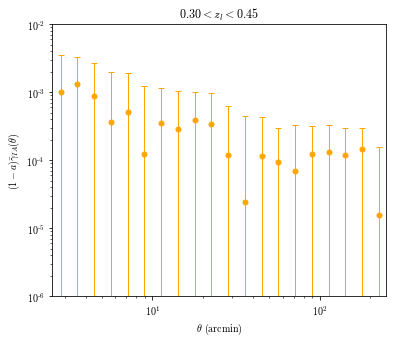

In [40]:
IA_jk = np.zeros(nbins)
IA_var = np.zeros([nbins])
for i in range(nbins):
    
    patch = IA_signal[:,i]
    IA_jk[i] = 1.0/npatches * np.sum(patch)
    
    # each row of GammaT_patches corresponds to an x_i estimate
    IA_var[i] = (npatches-1.0)/npatches * np.sum((IA_signal[:,i] - IA_jk[i])**2) # sum over x_i - x
    
IA_sig = np.sqrt(IA_var)

print(IA_sig)

plt.figure(figsize=[6,5])
plt.errorbar(IA_theta[0,:], IA_jk, yerr=IA_sig, lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}(\theta)$')
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('IA_prelim_measurement.png', dpi=300)

### Test Jackknife pipeline for Im3 and Metacal separately

In [13]:
mcal_patches = np.zeros([npatches, nbins])
theta_patches = np.zeros_like(mcal_patches)
im3_patches = np.zeros_like(mcal_patches)
boost_patches = np.zeros_like(mcal_patches)
F_patches = np.zeros([npatches])
IA_patches = np.zeros_like(mcal_patches)

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
# pass in npatch arguement to create catalogue using patches    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=npatches)

del data, ra_l, dec_l, w_l

print('lens catalogue created...')

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    rand_z = data['z'][indexes]

# define patches based on patches from lens catalogue so all catalogues use the same patches    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', r=rand_z, patch_centers=cat_l.patch_centers)

del data, ra_r, dec_r, indexes

# read in metacalibration data
with fits.open(data_dir+mcal_file) as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1']
    e2 = data['e2']
    R11 = data['R11'] # e1-e1

# responsivity values for this patch
cat_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=R11, g1=e1, g2=e2, patch_centers=cat_l.patch_centers)

del data, ra_s, dec_s, e1, e2, R11

with fits.open(data_dir+im3_file) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1'] - data['c1']
    e2 = data['e2'] - data['c2']
    sens = data['m'] + 1.0
    w = data['weight']
del data

# load in z_mc for all sources
with fits.open(data_dir+source_Zs) as hdu:
    data = hdu[1].data
    im3_zmc = data['z_mc']
    zmc_ID = data['coadd_objects_id']
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

# slice z_mc values to only to those in matched catalogue
im3_zmc = im3_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID, im3_ID

cat_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=im3_zmc, g1=e1, g2=e2, w=w, patch_centers=cat_l.patch_centers)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w, patch_centers=cat_l.patch_centers)

del ra_s, dec_s, e1, e2, sens, w, im3_zmc

print('ALL CATALOGUES READY')

#loop to exclude 1 patch at a time
print('Beginning Jackknife estimate...')
for i in range(npatches):
    
    start = time.time()
    
    #locate patch in catlogues
    l_indexes = list(locate(cat_l.patch, lambda x: x != i))
    r_indexes = list(locate(cat_r.patch, lambda x: x != i))
    mcal_indexes = list(locate(cat_mcal.patch, lambda x: x != i))
    im3_indexes = list(locate(cat_im3.patch, lambda x: x != i))
    k_indexes = list(locate(cat_k.patch, lambda x: x != i))
    
    print('Patch %g located...' %i)
    
    #create new catalogues with this patch missing
    jk_l = treecorr.Catalog(ra=cat_l.ra[l_indexes], dec=cat_l.dec[l_indexes], ra_units='rad', dec_units='rad', w=cat_l.w[l_indexes])
    
    jk_r = treecorr.Catalog(ra=cat_r.ra[r_indexes], dec=cat_r.dec[r_indexes], ra_units='rad', dec_units='rad')
    
    jk_mcal = treecorr.Catalog(ra=cat_mcal.ra[mcal_indexes], dec=cat_mcal.dec[mcal_indexes], ra_units='rad', dec_units='rad', g1=cat_mcal.g1[mcal_indexes], 
                                g2=cat_mcal.g2[mcal_indexes])
    
    jk_im3 = treecorr.Catalog(ra=cat_im3.ra[im3_indexes], dec=cat_im3.dec[im3_indexes], ra_units='rad', dec_units='rad', g1=cat_im3.g1[im3_indexes], 
                                g2=cat_im3.g2[im3_indexes], w=cat_im3.w[im3_indexes])
    
    jk_k = treecorr.Catalog(ra=cat_k.ra[k_indexes], dec=cat_k.dec[k_indexes], ra_units='rad', dec_units='rad', k=cat_k.k[k_indexes], 
                                w=cat_k.w[k_indexes])

    #mcal response
    R = np.mean(cat_mcal.r[mcal_indexes])
    
    #variables for F
    source_z = cat_im3.r[im3_indexes]
    rand_z = cat_r.r[r_indexes]
    source_weights = cat_im3.w[im3_indexes]
    
    print('Number of sources in patch: %f' %jk_mcal.nobj)
    print('Total number of sources: %f' %cat_mcal.nobj)
    
    del l_indexes, r_indexes, mcal_indexes, k_indexes, im3_indexes
    
    mcal_patches[i,:], theta_patches[i,:] = mcal_tangential_shear(cat_l=jk_l, cat_s=jk_mcal, cat_r=jk_r, nbins=nbins, R=R)
     
    print('mcal shear calculation complete...')
    
    im3_patches[i,:], theta_patches[i,:] = im3_tangential_shear(cat_l=jk_l, cat_s=jk_im3, cat_k=jk_k, cat_r=jk_r, nbins=nbins)
    
    print('im3 shear calculation complete...')
    
    boost_patches[i,:] = calculate_boost(cat_l=jk_l, cat_s=jk_im3, cat_r=jk_r, nbins=nbins)
    
    print('boost calculation complete...')
    
    F_patches[i] = des_functions.calculate_F(nbins=810, source_z=source_z, lens_z=rand_z, source_weights=source_weights)
    
    print('F calculation complete...')
    
    IA_patches[i,:] = (im3_patches[i,:] - mcal_patches[i,:]) / (boost_patches[i,:] - 1.0 + F_patches[i])

    end = time.time()
    diff = end-start
    
    del jk_l, jk_r, jk_mcal, jk_im3, jk_k, source_z, rand_z, source_weights
    

lens catalogue created...
ALL CATALOGUES READY
Beginning Jackknife estimate...
Patch 0 located...
Number of sources in patch: 16748946.000000
Total number of sources: 17865244.000000
mcal shear calculation complete...
im3 shear calculation complete...
boost calculation complete...
F calculation complete...
Patch 1 located...
Number of sources in patch: 17167274.000000
Total number of sources: 17865244.000000
mcal shear calculation complete...
im3 shear calculation complete...
boost calculation complete...
F calculation complete...
Patch 2 located...
Number of sources in patch: 17126882.000000
Total number of sources: 17865244.000000
mcal shear calculation complete...
im3 shear calculation complete...
boost calculation complete...
F calculation complete...
Patch 3 located...
Number of sources in patch: 17217773.000000
Total number of sources: 17865244.000000
mcal shear calculation complete...
im3 shear calculation complete...
boost calculation complete...
F calculation complete...
Patch

In [10]:
F = []
boost = np.zeros([nbins])
im3_tang = np.zeros_like(boost)
mcal_tang = np.zeros_like(boost)
IA_signal = np.zeros_like(boost)
theta = np.zeros_like(boost)
# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
# pass in npatch arguement to create catalogue using patches    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l)

del data, ra_l, dec_l, w_l

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    rand_z = data['z'][indexes]

# define patches based on patches from lens catalogue so all catalogues use the same patches    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg')

del data, ra_r, dec_r, indexes

# read in metacalibration data
with fits.open(data_dir+mcal_file) as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1']
    e2 = data['e2']
    R11 = data['R11'] # e1-e1

# responsivity values for this patch
cat_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2)
R = np.mean(R11)

del data, ra_s, dec_s, e1, e2, R11

with fits.open(data_dir+im3_file) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1'] - data['c1']
    e2 = data['e2'] - data['c2']
    sens = data['m'] + 1.0
    w = data['weight']
del data

# load in z_mc for all sources
with fits.open(data_dir+source_Zs) as hdu:
    data = hdu[1].data
    im3_zmc = data['z_mc']
    zmc_ID = data['coadd_objects_id']
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

# slice z_mc values to only to those in matched catalogue
im3_zmc = im3_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID, im3_ID

cat_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, w=w)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w)

del ra_s, dec_s, e1, e2, sens, w

source_z = im3_zmc
source_weights = cat_im3.w

print('ALL CATALOGUES READY')

mcal_tang, theta = mcal_tangential_shear(cat_l=cat_l, cat_s=cat_mcal, cat_r=cat_r, nbins=nbins, R=R)

print('mcal shear calculation complete...')

im3_tang, theta = im3_tangential_shear(cat_l=cat_l, cat_s=cat_im3, cat_k=cat_k, cat_r=cat_r, nbins=nbins)

print('im3 shear calculation complete...')

boost = calculate_boost(cat_l=cat_l, cat_s=cat_im3, cat_r=cat_r, nbins=nbins)

print('boost calculation complete...')

F = des_functions.calculate_F(nbins=810, source_z=source_z, lens_z=rand_z, source_weights=source_weights)

print('F calculation complete...')

IA_signal = (im3_tang - mcal_tang) / (boost - 1.0 + F)

ALL CATALOGUES READY
mcal shear calculation complete...
im3 shear calculation complete...
boost calculation complete...
F calculation complete...


Jackknife estimates finalised, plotting data...
0.07324781674948302 0.0005771061117362205


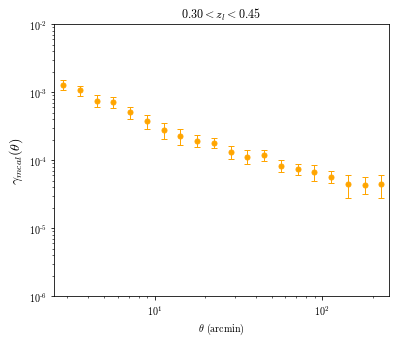

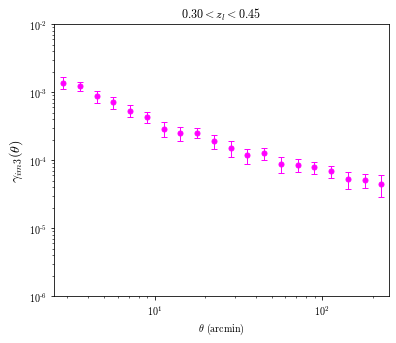

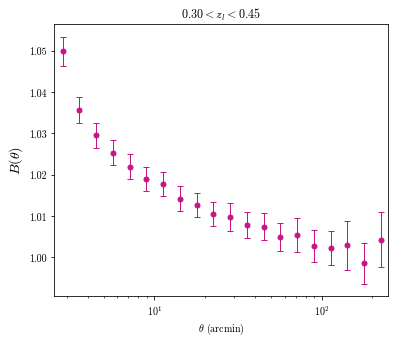

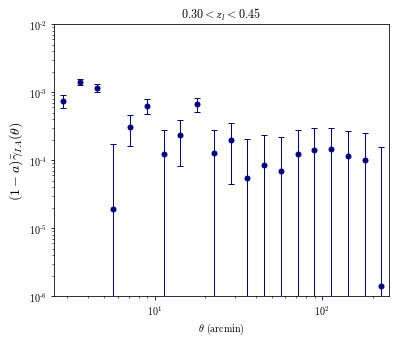

In [14]:
mcal_jk = np.zeros([nbins])
mcal_var = np.zeros([nbins])
mcal_theta = np.zeros([nbins])
im3_jk = np.zeros([nbins])
im3_var = np.zeros([nbins])
boost_jk = np.zeros([nbins])
boost_var = np.zeros([nbins])
IA_jk = np.zeros([nbins])
for i in range(nbins):
    
    #calculate mcal tang. shear from jackknife estimates
    patch = mcal_patches[:,i]
    mcal_jk[i] = 1.0/npatches * np.sum(patch)
    
    mcal_var[i] = (npatches-1.0)/npatches * np.sum((patch - mcal_jk[i])**2)
    
    #calcuate theta values from jackknife
    mcal_theta[i] = 1.0/npatches * np.sum(theta_patches[:,i])
    
    #calculate im3 tang. shear from jackknife estimates
    patch = im3_patches[:,i]
    im3_jk[i] = 1.0/npatches * np.sum(patch)
    
    im3_var[i] = (npatches-1.0)/npatches * np.sum((patch - im3_jk[i])**2)
    
    #calculate boost values from jackknife estimates
    patch = boost_patches[:,i]
    boost_jk[i] = 1.0/npatches * np.sum(patch)
    
    boost_var[i] = (npatches-1.0)/npatches * np.sum((patch - boost_jk[i])**2)
    
    #calculate IA signal from jackknife estimates
    patch = IA_patches[:,i]
    IA_jk[i] = 1.0/npatches * np.sum(patch)
    
    IA_var = (npatches-1.0)/npatches * np.sum((patch - IA_jk[i])**2)
    
#calculate F from IA estimates    
F = 1.0/npatches * np.sum(F_patches)
F_var = (npatches-1.0)/npatches * np.sum((F_patches - F)**2)
    
#finalise errors
mcal_var = np.sqrt(mcal_var)
im3_var = np.sqrt(im3_var)
boost_var = np.sqrt(boost_var)
F_var = np.sqrt(F_var)
IA_var = np.sqrt(IA_var)

print('Jackknife estimates finalised, plotting data...')

#plot all contributing variabales and IA signal, as well as value of F + error
plt.figure(figsize=[6,5])
plt.errorbar(theta, mcal_tang, yerr=mcal_var, lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\gamma_{mcal}(\theta)$', fontsize=14)
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('mcal_jackknife_matched_zl=0.3-0.45.png', dpi=300)

plt.figure(figsize=[6,5])
plt.errorbar(theta, im3_tang, yerr=im3_var, lw=0, marker='o', color='magenta', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\gamma_{im3}(\theta)$', fontsize=14)
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('im3_jackknife_matched_zl=0.3-0.45.png', dpi=300)

plt.figure(figsize=[6,5])
plt.errorbar(theta, boost, yerr=boost_var, lw=0, marker='o', color='mediumvioletred', markersize=5, elinewidth=1, capsize=3)
plt.xscale('log')
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$B(\theta)$', fontsize=14)
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('boost_jackknife_matched_zl=0.3-0.45.png', dpi=300)

plt.figure(figsize=[6,5])
plt.errorbar(theta, IA_signal, yerr=IA_var, lw=0, marker='o', color='navy', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}(\theta)$', fontsize=14)
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('IA_jackknife_matched_zl=0.3-0.45.png', dpi=300)

print(F, F_var)